In [7]:
# How many rows are there in tx?

import pandas as pd
tx = pd.read_csv("../data/external/transactions_train.csv")

len(tx)

259661

In [8]:
# Bring in the 'status' and 'groupId' columns from articles_clean and merge them into tx
a = pd.read_csv("../data/processed/articles_clean.csv", dtype="string", usecols=["sku", "status", "groupId"])
tx["sku"], a["sku"] = tx["sku"].str.strip(), a["sku"].str.strip()
# Merge status and groupId from articles into tx based on sku
tx = tx.merge(a[["sku", "status", "groupId"]], on="sku", how="left")
tx_sku, a_sku = pd.Index(tx["sku"].dropna().unique()), pd.Index(a["sku"].dropna().unique())
m = tx_sku.difference(a_sku)
print(f"Unique SKUs in tx: {len(tx_sku):,} | in articles: {len(a_sku):,}\nsku that are not in articles: {len(m):,}")

Unique SKUs in tx: 17,500 | in articles: 108,600
sku that are not in articles: 3


In [9]:
# Remove rows from tx where sku is not found in articles
tx = tx[tx["sku"].isin(a_sku)]

In [10]:
tx.sort_values("orderId", key=lambda x: x.astype(int)).head()

,orderId,shopUserId,created,currencyId,orderLineId,sku,quantity,price,name,status,groupId
259660,158790,78135,2024-05-22 12:38:29,50,454306.0,291294,1.0,11.3,Vasaravarpaan oikaisija 4/pak,active,291294
259659,158791,78136,2024-05-22 12:44:01,40,454308.0,542092,1.0,89.0,Tvättlappar enfärgade av frotté 5-pack,active,542087
259657,158800,78145,2024-05-22 12:54:51,40,454358.0,250209-0039,1.0,259.0,Hälsotoffel,inactive,250209
259658,158800,78145,2024-05-22 12:54:51,40,454359.0,261518,1.0,49.0,Bh-förlängare 3-pack,active,261518
259655,158805,78150,2024-05-22 12:59:31,134,454377.0,542252,1.0,179.0,Köksset 4-delar återvunnet material,inactive,542251


In [11]:
# What proportion of null values are there in tx?
tx.isnull().mean()

orderId        0.0
shopUserId     0.0
created        0.0
currencyId     0.0
orderLineId    0.0
sku            0.0
quantity       0.0
price          0.0
name           0.0
status         0.0
groupId        0.0
dtype: float64

## Remove known bugs

In [12]:

# Remove rows where 'created' date is 2024-05-26, 2024-05-27, 2024-05-28, or 2024-05-29 (bugs)
tx['created'] = pd.to_datetime(tx['created'], errors='coerce')
dates_to_remove = pd.to_datetime(['2024-05-21', '2024-05-26', '2024-05-27', '2024-05-28', '2024-05-29'])
tx = tx[~tx['created'].dt.normalize().isin(dates_to_remove)]


In [13]:
print(len(tx))

250042


In [14]:
# Save mapping between each individual SKU and its sku_family for later use
import os

import re
def extract_sku_family(sku):
    # Remove trailing SE, NO, FI, DK (case-insensitive) if present
    sku_base = re.sub(r'(SE|SV|NO|FI|DK)$', '', str(sku), flags=re.IGNORECASE)
    # Take part before '-' if present
    return sku_base.split('-')[0]
tx.insert(tx.columns.get_loc('sku') + 1, 'sku_family', tx['sku'].apply(extract_sku_family))


## Unify currenies to SEK for price bucketing

In [15]:
# Source: ECB euro foreign exchange reference rates (2025-08-18)
# https://www.ecb.europa.eu/stats/eurofxref/ (rates are indicative; updated ~16:00 CET on banking days)

# Map currencyId to country code: 40=DK, 134=SE, 103=NO, 50=FI
currencyid_to_country = {
    40: "DK",
    134: "SE",
    103: "NO",
    50: "FI"
}

conversion_rates = {
    "DK": 1.494795,  # Danish krone -> SEK
    "NO": 0.938825,  # Norwegian krone -> SEK
    "SE": 1.0,       # Swedish krona -> SEK
    "FI": 11.1570    # Finland (EUR) -> SEK
}

# Map currencyId to country code
tx["currency_country"] = tx["currencyId"].map(currencyid_to_country)

# Map to each row
tx["sek_rate"] = tx["currency_country"].map(conversion_rates)

# Safety: flag any unmapped currencyIds
missing = tx["sek_rate"].isna()
if missing.any():
    print("Warning: missing SEK rate for currencyIds:", tx.loc[missing, "currencyId"].unique())

# Ensure price is numeric, then compute
tx["price"] = pd.to_numeric(tx["price"], errors="coerce")
tx["price_sek"] = tx["price"] * tx["sek_rate"]

In [16]:
tx['price_sek'].sort_values(ascending=False).head(10)

118963    671759.378205
200879      7098.781455
106847      5556.186000
65755       5515.793550
220976      5515.793550
32302       5515.793550
39090       5515.793550
225427      5515.793550
26878       5515.793550
131092      5515.793550
Name: price_sek, dtype: float64

In [17]:
# Remove rows where the price value is 6 digits
tx = tx[~tx['price'].astype(str).str.replace('.0$', '', regex=True).str.fullmatch(r'\d{6}')]

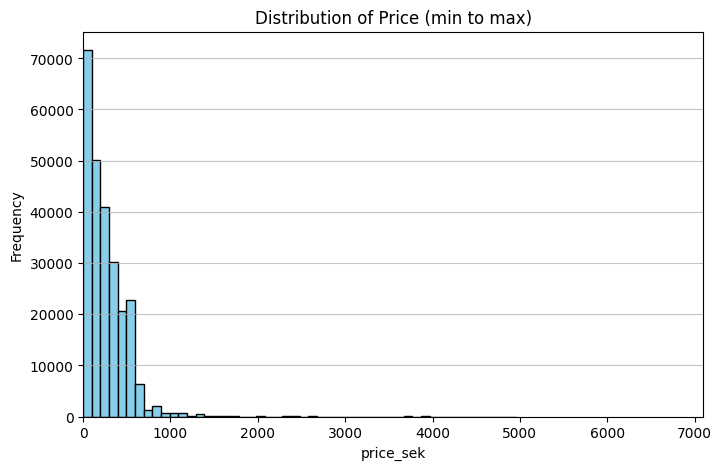

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(
    tx["price"].dropna(), 
    bins=50, 
    color="skyblue", 
    edgecolor="black"
)
plt.title("Distribution of Price (min to max)")
plt.xlabel("price_sek")
plt.ylabel("Frequency")
plt.xlim(tx["price_sek"].min(), tx["price_sek"].max())
plt.grid(axis='y', alpha=0.75)
plt.show()


In [19]:
# Merge age info from customers into transactions
customers = pd.read_csv("../data/processed/customers_clean.csv", dtype={"shopUserId": str})
tx['shopUserId'] = tx['shopUserId'].astype(str)
tx = tx.merge(customers[['shopUserId', 'Age']], on='shopUserId', how='left')

In [20]:
tx.isna().mean()

orderId             0.000000
shopUserId          0.000000
created             0.000000
currencyId          0.000000
orderLineId         0.000000
sku                 0.000000
sku_family          0.000000
quantity            0.000000
price               0.000000
name                0.000000
status              0.000000
groupId             0.000000
currency_country    0.000000
sek_rate            0.000000
price_sek           0.000000
Age                 0.503653
dtype: float64

In [21]:
# Save cleaned transactions to CSV
tx.to_csv("../data/processed/transactions_clean.csv", index=False)

 compute order-level user history (past order count, recency in seconds/log, and average past basket value) and merge it back to each line, so every row has the same past-user context without leaking the current order. We then add leave-one-line-out basket features (sum/qty/lines/avg unit price excluding the current line) and calendar features (hour, weekday/weekend, month, quarter) from order_created. 

In [71]:
# aggregate rows based on orderId (object dtypes OK, in-place edits)

import pandas as pd
import numpy as np

# --- Parse numerics & time from object ---
tx.loc[:, 'created']  = pd.to_datetime(tx['created'], errors='coerce')
tx.loc[:, 'quantity'] = pd.to_numeric(tx['quantity'], errors='coerce').fillna(1).clip(lower=1).round().astype('Int64')
tx.loc[:, 'price_sek']    = pd.to_numeric(tx['price'], errors='coerce').round().astype('Int64')

# Line total (no decimals)
tx.loc[:, '_line_total'] = (tx['price'] * tx['quantity']).round().astype('Int64')

# --- One row per orderId ---
orders = (
    tx.sort_values(['orderId','created'])
      .groupby('orderId', as_index=False)
      .agg(
          shopUserId    = ('shopUserId','first'),
          order_created = ('created','min'),
          total_qty     = ('quantity','sum'),
          basket_value  = ('_line_total','sum'),
          currencyId    = ('currencyId','first')
      )
)

# Ensure basket_value and total_qty are integers (no decimals)
orders['total_qty'] = orders['total_qty'].astype(int)
orders['basket_value'] = orders['basket_value'].astype(int)
orders['avg_unit_price'] = (orders['basket_value'] / orders['total_qty']).round().astype(int)

# SKUs per order (unique, sorted) — stays object list
sku_list = (
    tx.groupby('orderId')['sku']
      .apply(lambda s: sorted(pd.Series(s, dtype='string').dropna().unique().tolist()))
      .rename('sku_list')
)
orders = orders.merge(sku_list, on='orderId', how='left')

print(orders.head(10).to_string(index=False))


 orderId shopUserId       order_created  total_qty  basket_value  currencyId  avg_unit_price                                sku_list
  158790      78135 2024-05-22 12:38:29          1            11          50              11                                [291294]
  158791      78136 2024-05-22 12:44:01          1            89          40              89                                [542092]
  158800      78145 2024-05-22 12:54:51          2           308          40             154                   [250209-0039, 261518]
  158805      78150 2024-05-22 12:59:31          3          1075         134             358           [200226, 250116-0042, 542252]
  158808      78150 2024-05-22 13:07:10          1           418         134             418                           [270482-4446]
  158817      78162 2024-05-22 13:23:46          1           149         103             149                           [210643-3638]
  158818      78162 2024-05-22 13:24:47          1           119     

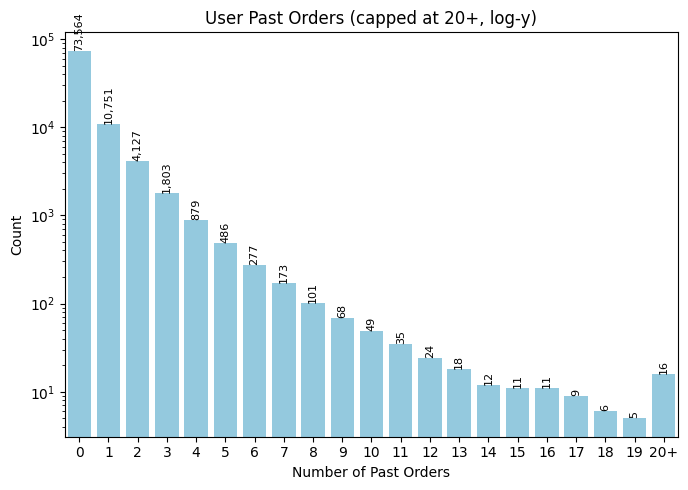

In [72]:
# Plot 1: Past orders (no columns written to `orders`)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

o = orders.sort_values(['shopUserId','order_created','orderId'])
past = o.groupby('shopUserId').cumcount().astype('Int32')           # 0,1,2,...
past_cap = past.clip(upper=20)

bins   = list(range(0, 21)) + [np.inf]
labels = [str(i) for i in range(0, 20)] + ['20+']
past_cat = pd.cut(past_cap, bins=bins, right=False, labels=labels, include_lowest=True)

plt.figure(figsize=(7,5))
ax = sns.countplot(x=past_cat, color='skyblue')
ax.set_yscale('log')
ax.set_title('User Past Orders (capped at 20+, log-y)')
ax.set_xlabel('Number of Past Orders'); ax.set_ylabel('Count')

for p in ax.patches:
    h = int(p.get_height())
    if h > 0:
        ax.annotate(f'{h:,}', (p.get_x()+p.get_width()/2., h),
                    ha='center', va='bottom', fontsize=8, rotation=90)

plt.tight_layout(); plt.show()


In [73]:
# Customers who ordered once vs. more than once, and more than twice
order_counts = orders.groupby('shopUserId')['orderId'].nunique()

one_time_customers   = int((order_counts == 1).sum())
repeat_customers     = int((order_counts > 1).sum())
more_than_two_customers = int((order_counts > 2).sum())
total_customers      = int(order_counts.size)

print(f"One-time customers:      {one_time_customers:,} ({one_time_customers/total_customers*100:.1f}%)")
print(f"Repeat customers:        {repeat_customers:,} ({repeat_customers/total_customers*100:.1f}%)")
print(f"More than 2 orders:      {more_than_two_customers:,} ({more_than_two_customers/total_customers*100:.1f}%)")


One-time customers:      62,813 (85.4%)
Repeat customers:        10,751 (14.6%)
More than 2 orders:      4,127 (5.6%)


In [74]:
# Same-user, same-day orders (calendar day) and check if those orders have the same total price

import pandas as pd

# ensure datetime
orders['order_created'] = pd.to_datetime(orders['order_created'], errors='coerce')

# calendar day
orders['_order_date'] = orders['order_created'].dt.floor('D')

# aggregate per (user, day)
same_day = (orders
    .groupby(['shopUserId','_order_date'], as_index=False)
    .agg(
        n_orders=('orderId','nunique'),
        orderIds=('orderId', lambda s: sorted(s.tolist())),
        times=('order_created', lambda s: sorted(s.dt.strftime('%H:%M:%S').tolist())),
        basket_values=('basket_value', lambda s: sorted(s.tolist()))
    )
)

# keep only days with 2+ orders
same_day_multi = same_day.query('n_orders > 1').sort_values(['n_orders', '_order_date', 'shopUserId'], ascending=[False, True, True])

# Check if all basket_values are the same for each group
def all_equal(lst):
    return len(set(lst)) == 1 if len(lst) > 1 else True

same_day_multi['same_total_price'] = same_day_multi['basket_values'].apply(all_equal)

print(f"Users with multiple orders on the same day: {same_day_multi.shape[0]}")
print(same_day_multi[['shopUserId', '_order_date', 'n_orders', 'orderIds', 'times', 'basket_values', 'same_total_price']].head(10).to_string(index=False))


Users with multiple orders on the same day: 753
shopUserId _order_date  n_orders                                         orderIds                                                        times                        basket_values  same_total_price
    183783  2024-09-02         6 [284522, 284542, 284545, 284552, 284557, 284563] [12:32:27, 12:40:17, 12:41:25, 12:42:53, 12:44:51, 12:46:16]       [279, 298, 398, 458, 498, 498]             False
    654825  2025-05-21         6 [709594, 709601, 709604, 709654, 709670, 709682] [11:26:01, 11:26:48, 11:27:53, 11:30:05, 11:35:14, 11:40:26] [1274, 1274, 1274, 1274, 1274, 1274]              True
    703767  2025-04-16         5         [665013, 665017, 665025, 665029, 665045]           [17:33:15, 17:38:46, 17:43:46, 17:48:28, 18:01:02]            [139, 149, 278, 298, 298]             False
    262090  2024-06-24         4                 [192175, 192347, 192367, 192415]                     [09:38:27, 11:55:01, 12:06:48, 12:41:22]                 [

In [75]:
# Dedup: same user + same day + identical basket_value across the day -> keep earliest, drop others

import pandas as pd

# ensure datetime & numeric
orders['order_created'] = pd.to_datetime(orders['order_created'], errors='coerce')
orders['basket_value']  = pd.to_numeric(orders['basket_value'], errors='coerce')

# work per (user, day)
orders['_order_date'] = orders['order_created'].dt.floor('D')
orders.sort_values(['shopUserId','_order_date','order_created','orderId'], inplace=True)

grp = orders.groupby(['shopUserId','_order_date'])
same_total = grp['basket_value'].transform('nunique').eq(1)     # all totals equal within the day?
multi_in_day = grp['orderId'].transform('nunique').gt(1)        # 2+ orders that day?
orders['__seq'] = grp.cumcount()                                # 0 = earliest in that day

mask_dup = multi_in_day & same_total & (orders['__seq'] > 0)

n_before = len(orders)
orders.drop(index=orders.index[mask_dup], inplace=True)
orders.drop(columns=['_order_date','__seq'], inplace=True, errors='ignore')
orders.sort_values(['shopUserId','order_created','orderId'], inplace=True)

print(f"Removed {n_before - len(orders)} duplicate same-day orders with identical totals.")
print(orders.head(10).to_string(index=False))

Removed 469 duplicate same-day orders with identical totals.
 orderId shopUserId       order_created  total_qty  basket_value  currencyId  avg_unit_price                                sku_list
  290862     100102 2024-09-06 18:41:18          1           119         134             119                           [261595-4450]
  171345     100140 2024-06-06 17:00:43          3          1127          40             376 [260451-4095, 261544-D095, 261555-D095]
  289419     100140 2024-09-05 14:58:33          3          1107          40             369 [260451-4095, 261544-D095, 265835-4095]
  334653     100140 2024-10-03 16:14:38          3          1107          40             369 [260451-4090, 261544-D090, 265835-4090]
  459823     100140 2024-12-02 17:28:53          2           768          40             384              [261554-D090, 261687-4090]
  566013     100140 2025-02-02 11:54:52          2           738          40             369              [260451-5090, 264549-5090]
  616637

kept 18,024/18,392 gaps | min kept≈0.0d, max kept≈345.3d


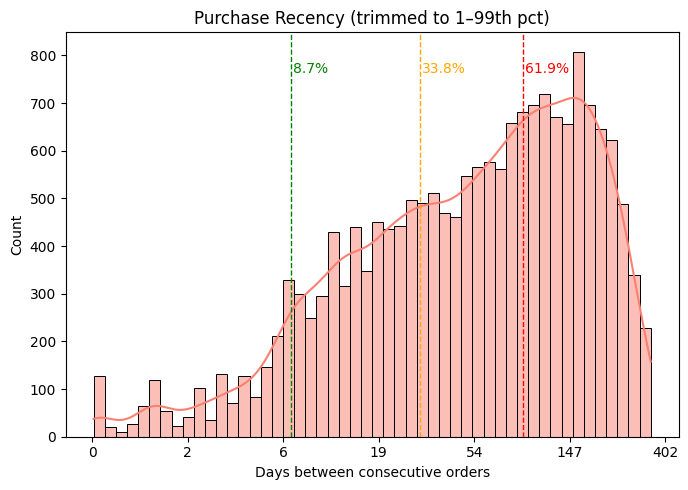

median=59.9d | p75=134.9d | p90=210.9d


In [76]:
# Plot 2: Purchase recency — quantile-based trimming on both ends

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# sort (no writes to `orders`)
idx = orders.sort_values(['shopUserId','order_created','orderId']).index
oc  = pd.to_datetime(orders.loc[idx, 'order_created'], errors='coerce')

# break ties (same user+timestamp)
tiebreak = orders.loc[idx].groupby(['shopUserId','order_created']).cumcount()
adj = oc + pd.to_timedelta(tiebreak, unit='s')

# recency in days (exclude first orders)
recency_days = adj.groupby(orders.loc[idx, 'shopUserId']).diff().dt.total_seconds().div(86400).dropna()

# quantile-based trim
q_low, q_high = 0.01, 0.99
min_d = float(recency_days.quantile(q_low))
cap_d = float(recency_days.quantile(q_high))
rd = recency_days[(recency_days >= min_d) & (recency_days <= cap_d)]

print(f"kept {len(rd):,}/{len(recency_days):,} gaps | "
      f"min kept≈{min_d:.1f}d, max kept≈{cap_d:.1f}d")

# log1p binning; label axis in real days
x = np.log1p(rd)
plt.figure(figsize=(7,5))
ax = sns.histplot(x, bins=50, kde=True, color='salmon')

for d, c in [(7,'green'), (30,'orange'), (90,'red')]:
    if min_d <= d <= cap_d:
        ax.axvline(np.log1p(d), ls='--', color=c, lw=1)
        ax.text(np.log1p(d)+0.02, ax.get_ylim()[1]*0.9, f'{(rd<=d).mean()*100:.1f}%', color=c)

ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f'{np.expm1(v):.0f}'))
ax.set_title(f'Purchase Recency (trimmed to {int(q_low*100)}–{int(q_high*100)}th pct)')
ax.set_xlabel('Days between consecutive orders'); ax.set_ylabel('Count')
plt.tight_layout(); plt.show()

# quick stats on trimmed distribution
print(f"median={rd.median():.1f}d | p75={rd.quantile(.75):.1f}d | p90={rd.quantile(.90):.1f}d")


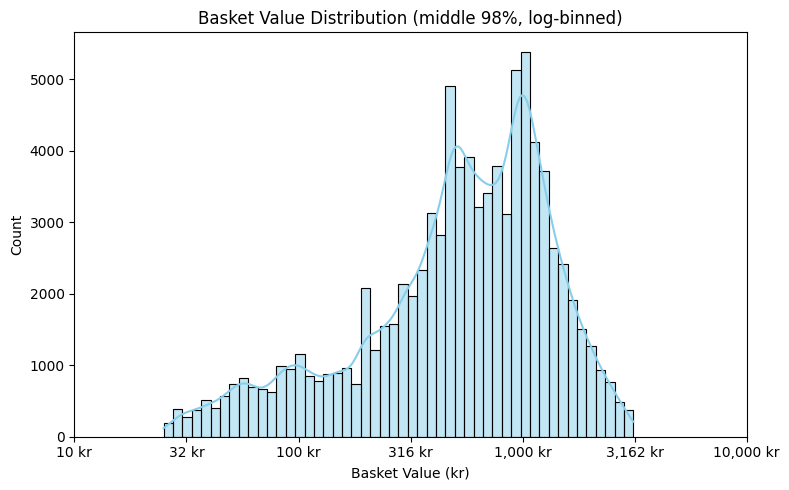

Removed values below 25 kr and above 3,118 kr


In [77]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Remove zero/negative values
basket_vals = orders['basket_value']
basket_vals = basket_vals[basket_vals > 0]

# Define lower and upper percentiles for trimming
low_p, high_p = 0.01, 0.99  # keep middle 98% of orders
low_val, high_val = basket_vals.quantile([low_p, high_p])

# Filter within range
basket_vals = basket_vals[(basket_vals >= low_val) & (basket_vals <= high_val)]

# Log transform
log_basket = np.log10(basket_vals)

plt.figure(figsize=(8,5))
sns.histplot(log_basket, bins=50, color='skyblue', kde=True)

# Back-transform ticks to kr
xticks = plt.xticks()[0]
xtick_labels = [f"{10**x:,.0f} kr" for x in xticks]
plt.xticks(ticks=xticks, labels=xtick_labels)

plt.title(f'Basket Value Distribution (middle 98%, log-binned)')
plt.xlabel('Basket Value (kr)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Optional: show cutoffs
print(f"Removed values below {low_val:,.0f} kr and above {high_val:,.0f} kr")


In [78]:
len(orders)

91956

In [79]:
# STEP 1 — Prepare transaction-level lines (one row per SKU line)

import pandas as pd
import numpy as np

# Parse dtypes
tx.loc[:, 'created']  = pd.to_datetime(tx['created'], errors='coerce')
tx.loc[:, 'quantity'] = pd.to_numeric(tx['quantity'], errors='coerce').fillna(1).clip(lower=1)
tx.loc[:, 'price']    = pd.to_numeric(tx['price'],    errors='coerce')

# Ensure per-line features
if 'unit_price' not in tx.columns:
    tx['unit_price'] = tx['price']
if 'line_value' not in tx.columns:
    tx['line_value'] = tx['price'] * tx['quantity']

# Stable within-order ordering
sort_cols = ['shopUserId','orderId','created']
if 'orderLineId' in tx.columns:
    sort_cols.append('orderLineId')

txL = tx.sort_values(sort_cols).reset_index(drop=True)

# Quick peek
print(txL[['shopUserId','orderId','created','sku','quantity','unit_price','line_value']]
      .head(50).to_string(index=False))


shopUserId  orderId             created         sku  quantity  unit_price  line_value
    100102   290862 2024-09-06 18:41:18 261595-4450       1.0      119.00      119.00
    100140   171345 2024-06-06 17:00:43 260451-4095       1.0      369.00      369.00
    100140   171345 2024-06-06 17:00:43 261544-D095       1.0      369.00      369.00
    100140   171345 2024-06-06 17:00:43 261555-D095       1.0      389.00      389.00
    100140   289419 2024-09-05 14:58:33 265835-4095       1.0      369.00      369.00
    100140   289419 2024-09-05 14:58:33 261544-D095       1.0      369.00      369.00
    100140   289419 2024-09-05 14:58:33 260451-4095       1.0      369.00      369.00
    100140   334653 2024-10-03 16:14:38 265835-4090       1.0      369.00      369.00
    100140   334653 2024-10-03 16:14:38 260451-4090       1.0      369.00      369.00
    100140   334653 2024-10-03 16:14:38 261544-D090       1.0      369.00      369.00
    100140   459823 2024-12-02 17:28:53 261554-D090   

In [80]:
# STEP 2 — Add leak-safe prefix features (no labels yet)

import pandas as pd
import numpy as np

txL = txL.copy()
g = txL.groupby('orderId', sort=False)

# Position and prefixes (exclude current line)
txL['pos_in_order'] = g.cumcount()
txL['lines_so_far'] = txL['pos_in_order']
txL['qty_so_far']   = g['quantity'].cumsum()   - txL['quantity']
txL['value_so_far'] = g['line_value'].cumsum() - txL['line_value']

# Feature view for the dataset (adjust as needed)
feature_cols = [
    'shopUserId','orderId','created','sku','quantity','unit_price','line_value',
    'pos_in_order','lines_so_far','qty_so_far','value_so_far'
]
feature_cols = [c for c in feature_cols if c in txL.columns]
dataset_lines = txL[feature_cols]

print(dataset_lines.head(10).to_string(index=False))


shopUserId  orderId             created         sku  quantity  unit_price  line_value  pos_in_order  lines_so_far  qty_so_far  value_so_far
    100102   290862 2024-09-06 18:41:18 261595-4450       1.0       119.0       119.0             0             0         0.0           0.0
    100140   171345 2024-06-06 17:00:43 260451-4095       1.0       369.0       369.0             0             0         0.0           0.0
    100140   171345 2024-06-06 17:00:43 261544-D095       1.0       369.0       369.0             1             1         1.0         369.0
    100140   171345 2024-06-06 17:00:43 261555-D095       1.0       389.0       389.0             2             2         2.0         738.0
    100140   289419 2024-09-05 14:58:33 265835-4095       1.0       369.0       369.0             0             0         0.0           0.0
    100140   289419 2024-09-05 14:58:33 261544-D095       1.0       369.0       369.0             1             1         1.0         369.0
    100140   289419 

In [81]:
import numpy as np
import pandas as pd

# --- Recompute per-user history on cleaned `orders` ---
orders = orders.sort_values(['shopUserId','order_created','orderId']).copy()

# break exact timestamp ties so 0-gaps aren’t artifacts
tb = orders.groupby(['shopUserId','order_created']).cumcount()
orders['order_created_adj'] = pd.to_datetime(orders['order_created'], errors='coerce') + pd.to_timedelta(tb, unit='s')

# past orders (0 for first), recency (sec)
orders['user_past_orders'] = orders.groupby('shopUserId').cumcount().astype('Int32')
orders['user_recency_sec'] = (orders.groupby('shopUserId')['order_created_adj']
                              .diff().dt.total_seconds().fillna(-1))

# recency -> hours, cap at p99, log1p
rec_h = orders['user_recency_sec'].clip(lower=0) / 3600.0
cap_h = np.nanpercentile(rec_h[rec_h.notna()], 99) if rec_h.notna().any() else 0.0
orders['user_recency_hours'] = np.clip(rec_h, 0, cap_h)
orders['user_recency_log']   = np.log1p(orders['user_recency_hours'])

# stabilized past order count
orders['user_past_orders_log'] = np.log1p(orders['user_past_orders'])

# leakage-safe left-exclusive EWMA of basket_value
alpha = 0.30
orders['user_avg_basket_value'] = (
    orders.groupby('shopUserId')['basket_value']
          .apply(lambda s: s.shift(1).astype(float).ewm(alpha=alpha, adjust=False).mean())
          .fillna(0.0)
)

# --- Merge minimal order context back to lines for ranking ---
# ensure base line features exist
if 'line_value' not in tx.columns:
    tx['line_value'] = pd.to_numeric(tx['price'], errors='coerce') * pd.to_numeric(tx['quantity'], errors='coerce')
if 'unit_price' not in tx.columns:
    tx['unit_price'] = pd.to_numeric(tx['price'], errors='coerce')

tx = tx.merge(
    orders[['shopUserId','orderId','order_created','basket_value',
            'user_past_orders','user_past_orders_log',
            'user_recency_hours','user_recency_log','user_avg_basket_value']],
    on=['shopUserId','orderId'], how='left'
)

# --- Leave-one-line-out basket context (quantity-weighted) ---
g = tx.groupby('orderId', dropna=False)
sum_val = g['line_value'].transform('sum')
sum_qty = g['quantity'].transform('sum')
n_lines = g['sku'].transform('size')

tx['basket_num_lines_excl']   = (n_lines - 1).clip(lower=0)
tx['basket_total_value_excl'] = (sum_val - tx['line_value']).fillna(0.0)
tx['basket_total_qty_excl']   = (sum_qty - tx['quantity']).fillna(0)

# quantity-weighted avg unit price of *other* lines
den = tx['basket_total_qty_excl'].replace(0, np.nan)
tx['basket_avg_unit_price_excl'] = (tx['basket_total_value_excl'] / den).fillna(0.0)

# --- Time/context features ---
oc = pd.to_datetime(tx['order_created'], errors='coerce')
tx['year']      = oc.dt.year.astype('Int16')
tx['week']      = oc.dt.isocalendar().week.astype('Int16')
tx['hour']      = oc.dt.hour.astype('Int16')
tx['dayofweek'] = oc.dt.dayofweek.astype('Int8')
tx['is_weekend']= tx['dayofweek'].isin([5,6]).astype('Int8')
tx['month']     = oc.dt.month.astype('Int8')
tx['quarter']   = oc.dt.quarter.astype('Int8')

# cyclical encodings
tx['hour_sin'] = np.sin(2*np.pi*tx['hour']/24);   tx['hour_cos'] = np.cos(2*np.pi*tx['hour']/24)
tx['dow_sin']  = np.sin(2*np.pi*tx['dayofweek']/7); tx['dow_cos']  = np.cos(2*np.pi*tx['dayofweek']/7)

# activity flags (based on capped recency)
tx['active_30d'] = (tx['user_recency_hours'] <= 30*24).astype('Int8')
tx['active_90d'] = (tx['user_recency_hours'] <= 90*24).astype('Int8')

KeyboardInterrupt: 

Goal: Create one row per user–item interaction (the “positive” examples), with the user’s context at that time.

In [ ]:
import pandas as pd
import numpy as np

# --- minimal guards so .dt works ---
tx['created'] = pd.to_datetime(tx['created'], errors='coerce')   # ensure created is datetime

# Ensure order_created/year/week exist
if 'order_created' not in tx.columns:
    oc = (tx.groupby(['shopUserId','orderId'], as_index=False)['created']
            .min()
            .rename(columns={'created':'order_created'}))
    tx = tx.merge(oc, on=['shopUserId','orderId'], how='left')

tx['order_created'] = pd.to_datetime(tx['order_created'], errors='coerce')  # <-- make datetime

if 'year' not in tx.columns or 'week' not in tx.columns:
    tx['year'] = tx['order_created'].dt.year
    tx['week'] = tx['order_created'].dt.isocalendar().week.astype(int)  # week number only

# POSITIVES: one row per (user, order, sku) with compact context
pos = (tx.groupby(['shopUserId','orderId','sku','year','week','order_created',
                   'hour','dayofweek','is_weekend','month','quarter',
                   'user_past_orders','user_recency_log','user_avg_basket_value'],
                  as_index=False)
         .agg(quantity=('quantity','sum'),
              price=('price','mean'),
              line_value=('line_value','sum'),
              unit_price=('unit_price','mean'),
              basket_total_value_excl=('basket_total_value_excl','mean'),
              basket_total_qty_excl=('basket_total_qty_excl','mean'),
              basket_num_lines_excl=('basket_num_lines_excl','mean'),
              basket_avg_unit_price_excl=('basket_avg_unit_price_excl','mean')))
pos['label'] = 1

# Weekly context per user (latest order in that week)
pos['user_week_key'] = (pos['shopUserId'].astype(str) + '|' +
                        pos['year'].astype(str) + '|' +
                        pos['week'].astype(str))

uw_context = (pos.sort_values(['shopUserId','year','week','order_created'])
                .groupby(['shopUserId','year','week','user_week_key'], as_index=False)
                .tail(1)[['shopUserId','year','week','user_week_key','order_created',
                          'hour','dayofweek','is_weekend','month','quarter',
                          'user_past_orders','user_recency_log','user_avg_basket_value']])


In [ ]:
import pandas as pd, numpy as np

# Popular SKUs pool (simple candidate generator)
TOP_K = 50  # try 50/100 if you want
top_skus = (tx.groupby('sku')['orderId'].nunique()
              .sort_values(ascending=False)
              .head(TOP_K).index)

# Cross-join (user-week) × (top_skus), drop positives, then sample
user_weeks = pos[['shopUserId','year','week','user_week_key']].drop_duplicates()
neg_pool = (user_weeks.assign(key=1)
            .merge(pd.DataFrame({'sku': top_skus, 'key':1}), on='key', how='left')
            .drop('key', axis=1))
neg_pool = neg_pool.merge(pos[['user_week_key','sku']].drop_duplicates().assign(pos=1),
                          on=['user_week_key','sku'], how='left')
neg_pool = neg_pool[neg_pool['pos'].isna()].drop(columns='pos')

# k negatives per positive (per user-week)
k = 5
n_pos = pos.groupby('user_week_key').size().rename('n_pos')
neg_pool = neg_pool.merge(n_pos, on='user_week_key', how='left')
rng = np.random.default_rng(42)
neg_pool = (neg_pool.assign(rand=rng.random(len(neg_pool)))
                   .sort_values(['user_week_key','rand'])
                   .groupby('user_week_key', group_keys=False)
                   .apply(lambda g: g.head(int(g['n_pos'].iloc[0] * k)))
                   .drop(columns=['rand','n_pos']))

# Attach weekly context; fill item/basket with neutral values
negs = (neg_pool.merge(uw_context, on=['shopUserId','year','week','user_week_key'], how='left')
               .assign(orderId=np.nan, quantity=0, price=0.0, line_value=0.0, unit_price=0.0,
                       basket_total_value_excl=0.0, basket_total_qty_excl=0.0,
                       basket_num_lines_excl=0.0, basket_avg_unit_price_excl=0.0, label=0))

# Final UI training frame (keep keys for joins; drop before model.fit if desired)
cols = ['shopUserId','sku','orderId','order_created','hour','dayofweek','is_weekend','month','quarter',
        'user_past_orders','user_recency_log','user_avg_basket_value',
        'quantity','price','line_value','unit_price',
        'basket_total_value_excl','basket_total_qty_excl','basket_num_lines_excl','basket_avg_unit_price_excl',
        'year','week','user_week_key','label']
ui_train = (pd.concat([pos[cols], negs[cols]], ignore_index=True)
              .sample(frac=1.0, random_state=42)
              .reset_index(drop=True))

print(ui_train.shape, ui_train['label'].value_counts())

In [ ]:

from IPython.display import display, HTML
display(HTML('<div style="overflow-x:auto">' + ui_train.head(3).to_html() + '</div>'))


In [ ]:
ui_train.drop(columns=['orderId', "order_created"], inplace=True)

In [ ]:
import pandas as pd

# Load & normalize keys
articles = pd.read_csv("../data/processed/articles_clean.csv", dtype=str)
articles['sku'] = articles['sku'].str.strip()

# Normalize categoryId (take primary before any comma)
articles['categoryId_primary'] = articles['categoryId'].str.split(',').str[0].str.strip()

# Select columns and dedupe to 1 row/sku
use_cols = ['sku','brandId','categoryId_primary','colorId','audienceId','name','status']
articles = articles[use_cols].drop_duplicates('sku', keep='last')

# Merge into ui_train
ui_train['sku'] = ui_train['sku'].astype(str).str.strip()
ui_train = ui_train.merge(articles, on='sku', how='left', validate='m:1')

# LightGBM: mark categoricals
for c in ['brandId','categoryId_primary','colorId','audienceId']:
    ui_train[c] = ui_train[c].astype('category')

# Keep `status` only for filtering active items at inference
active_skus = set(ui_train.loc[ui_train['status'].str.lower()=='active','sku'])


In [ ]:

from IPython.display import display, HTML
display(HTML('<div style="overflow-x:auto">' + ui_train.head(3).to_html() + '</div>'))


In [ ]:

# Load + normalize keys
cust = pd.read_csv("../data/processed/customers_clean.csv", dtype="string")
cust = cust.rename(columns={"Gender":"gender","Age":"age"})
cust["shopUserId"] = cust["shopUserId"].str.strip()
ui_train["shopUserId"] = ui_train["shopUserId"].astype(str).str.strip()

# Keep only one row per customer (avoid row explosion)
cust = cust[["shopUserId","invoiceCountryId","gender","age"]].drop_duplicates("shopUserId", keep="last")

# Merge (m:1 expected)
ui_train = ui_train.merge(cust, on="shopUserId", how="left", validate="m:1")

# LightGBM-friendly dtypes / light cleaning
ui_train["invoiceCountryId"] = ui_train["invoiceCountryId"].astype("category")
ui_train["gender"] = (ui_train["gender"].str.strip().str.lower()
                      .map({"female":"female","male":"male"}).fillna("unknown").astype("category"))
ui_train["age"] = (pd.to_numeric(ui_train["age"], errors="coerce")
                   .clip(lower=0, upper=120).astype("Int16"))

# Fewer age buckets for trees/DNN
ui_train["age_bucket"] = pd.cut(
    ui_train["age"], 
    bins=[0,25,45,65,120],
    labels=["<25","25-44","45-64","65+"]
).astype("category")

# Fill missing age and age_bucket with special tokens
ui_train["age"] = ui_train["age"].astype("object").fillna("__UNK_AGE__")
ui_train["age_bucket"] = ui_train["age_bucket"].cat.add_categories(["__UNK_AGEBUCKET__"]).fillna("__UNK_AGEBUCKET__").astype("category")


In [ ]:

from IPython.display import display, HTML
display(HTML('<div style="overflow-x:auto">' + ui_train.head(3).to_html() + '</div>'))


In [ ]:
# Save the processed training data for later use
# Work around ArrowTypeError for 'age' column by ensuring all values are strings
ui_train_fixed = ui_train.copy()
if "age" in ui_train_fixed.columns:
    ui_train_fixed["age"] = ui_train_fixed["age"].astype(str)
ui_train_fixed.to_parquet("../data/processed/ui_train.parquet", index=False)
